# Credit Scorecard development case study

In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Data Loading

In [2]:
data = pd.read_excel('data/Dataset-case.xlsx')

In [3]:
# data.head()
data.sample(10)

,loan_status_2,loan_status,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,age,pay_status
2192,Charged off,1,11200,36,16.55,396.81,D2,0.0,MORTGAGE,55000.0,Source Verified,2015-01-03,home_improvement,IL,30.87,705,709,17,0,9543,53.0,0.0,0.0,38,0
9678,Fully paid,0,15000,36,19.42,553.04,D3,10.0,MORTGAGE,96000.0,Source Verified,2018-01-04,home_improvement,WI,15.24,695,699,13,0,1722,11.0,3.0,0.0,24,0
9114,Fully paid,0,12000,36,18.99,439.82,D4,3.0,RENT,76000.0,Source Verified,2016-01-04,debt_consolidation,IL,14.07,660,664,15,0,10723,47.9,0.0,0.0,39,-1
52228,Fully paid,0,30750,36,16.99,1096.17,D1,NaN,MORTGAGE,70000.0,Verified,2014-01-01,credit_card,PA,29.13,665,669,7,0,17299,99.4,2.0,0.0,32,2
14961,Fully paid,0,4575,36,12.29,152.59,C1,10.0,MORTGAGE,79500.0,Source Verified,2015-01-09,credit_card,CA,20.60,680,684,15,0,35429,71.1,4.0,0.0,37,0
41125,Fully paid,0,19800,60,16.49,486.67,D3,10.0,RENT,43500.0,Not Verified,2014-01-11,home_improvement,MS,14.26,700,704,14,0,583,3.9,1.0,0.0,23,0
50749,Fully paid,0,11200,36,10.91,366.20,B4,10.0,MORTGAGE,70000.0,Verified,2017-01-05,debt_consolidation,NV,19.13,670,674,12,0,9163,69.9,4.0,0.0,22,-1
48208,Fully paid,0,30000,60,13.99,697.90,C4,10.0,MORTGAGE,110000.0,Source Verified,2015-01-07,debt_consolidation,TX,13.70,680,684,11,0,26330,72.7,5.0,0.0,39,2
49370,Fully paid,0,22500,36,7.12,695.97,A3,4.0,MORTGAGE,144000.0,Source Verified,2014-01-10,debt_consolidation,VA,9.67,690,694,12,0,46662,58.8,3.0,0.0,63,0
40954,Charged off,1,6600,60,10.15,140.72,B2,1.0,RENT,45000.0,Source Verified,2014-01-07,major_purchase,MD,20.35,755,759,8,0,1417,28.3,0.0,0.0,50,3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58852 entries, 0 to 58851
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   loan_status_2         58852 non-null  object        
 1   loan_status           58852 non-null  int64         
 2   loan_amnt             58852 non-null  int64         
 3   term                  58852 non-null  int64         
 4   int_rate              58852 non-null  float64       
 5   installment           58852 non-null  float64       
 6   sub_grade             58852 non-null  object        
 7   emp_length            55510 non-null  float64       
 8   home_ownership        58852 non-null  object        
 9   annual_inc            58852 non-null  float64       
 10  verification_status   58852 non-null  object        
 11  issue_d               58852 non-null  datetime64[ns]
 12  purpose               58852 non-null  object        
 13  addr_state      

In [5]:
# Get the number of missing data points per column
data.isnull().sum()

loan_status_2              0
loan_status                0
loan_amnt                  0
term                       0
int_rate                   0
installment                0
sub_grade                  0
emp_length              3342
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
purpose                    0
addr_state                 0
dti                        0
fico_range_low             0
fico_range_high            0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                33
mort_acc                2039
pub_rec_bankruptcies      27
age                        0
pay_status                 0
dtype: int64

**Missing Values**

| Column                  | Missing Values |
--------------------------|----------------|
| emp_length |               3342 |
| revol_util |                 33 |
| mort_acc |                 2039 |
| pub_rec_bankruptcies |       27 |

In [6]:
# I should not remove any of the columns with missing values because they are all important
# Percedence of values missing is as follows:
data.isnull().mean().sort_values(ascending=False)

emp_length              0.056787
mort_acc                0.034646
revol_util              0.000561
pub_rec_bankruptcies    0.000459
loan_status_2           0.000000
addr_state              0.000000
age                     0.000000
revol_bal               0.000000
pub_rec                 0.000000
open_acc                0.000000
fico_range_high         0.000000
fico_range_low          0.000000
dti                     0.000000
purpose                 0.000000
loan_status             0.000000
issue_d                 0.000000
verification_status     0.000000
annual_inc              0.000000
home_ownership          0.000000
sub_grade               0.000000
installment             0.000000
int_rate                0.000000
term                    0.000000
loan_amnt               0.000000
pay_status              0.000000
dtype: float64

## Identify the target / dependent variable

In [7]:
# loan_status is the target variable
# Where Default = 1 and Non-Default = 0
data['loan_status'].value_counts()

0    47080
1    11772
Name: loan_status, dtype: int64

In [8]:
# Drop loan_status2 column as it is not needed anymore
data.drop(columns = ['loan_status_2'], inplace = True)

In [9]:
data.loan_status.value_counts(normalize=True)

0    0.799973
1    0.200027
Name: loan_status, dtype: float64

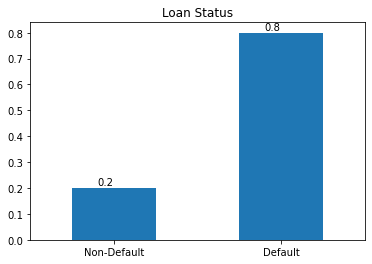

In [10]:
# Plot it as a bar chart
data.loan_status.value_counts(normalize=True).sort_values().plot(kind='bar')
plt.title('Loan Status')
# add Default instead of 1 and Non-Default instead of 0
plt.xticks([0, 1], ['Non-Default', 'Default'], rotation=0)
# show exact values
for i, v in enumerate(data.loan_status.value_counts(normalize=True).sort_values()):
    plt.text(i - 0.1, v + 0.01, str(round(v, 2)))
    
plt.show()

## Split the data into train and test sets

In [11]:
# Split the data into train and test (80-20 split)
# Use random_state = 42 to ensure that the results are reproducible
# Use stratify to ensure that the proportion of good and bad loans is the same in both train and test sets
X = data.drop(columns = 'loan_status', axis=1)
y = data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_test = X_train.copy(), X_test.copy()

In [12]:
X_train.shape, X_test.shape

((47081, 23), (11771, 23))

## Data Cleaning / Pre-processing

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58852 entries, 0 to 58851
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   loan_status           58852 non-null  int64         
 1   loan_amnt             58852 non-null  int64         
 2   term                  58852 non-null  int64         
 3   int_rate              58852 non-null  float64       
 4   installment           58852 non-null  float64       
 5   sub_grade             58852 non-null  object        
 6   emp_length            55510 non-null  float64       
 7   home_ownership        58852 non-null  object        
 8   annual_inc            58852 non-null  float64       
 9   verification_status   58852 non-null  object        
 10  issue_d               58852 non-null  datetime64[ns]
 11  purpose               58852 non-null  object        
 12  addr_state            58852 non-null  object        
 13  dti             

In [14]:
# emp_length
# Fill in the missing values with 0.
def emp_length_converter(df, column):
    df[column].fillna(value = 0, inplace = True)

# Apply to X_train
emp_length_converter(X_train, 'emp_length')

X_train['emp_length'].unique()
X_train['emp_length'].value_counts()

10.0    15618
0.0      6369
2.0      4293
3.0      3849
1.0      3036
5.0      2895
4.0      2831
6.0      2253
8.0      2126
7.0      2096
9.0      1715
Name: emp_length, dtype: int64

In [15]:
# issue_d

# Convert date columns to datetime format
# And create a new column as a difference between today and the respective date column
def date_converter(df, column):
    # store current month
    today_date = pd.to_datetime('2023-05-16')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

# apply to X_train
date_converter(X_train, 'issue_d')

# Check the new columns
print(X_train['mths_since_issue_d'].describe())



count    47081.000000
mean       100.959113
std         19.374397
min         64.000000
25%         88.000000
50%        100.000000
75%        112.000000
max        196.000000
Name: mths_since_issue_d, dtype: float64


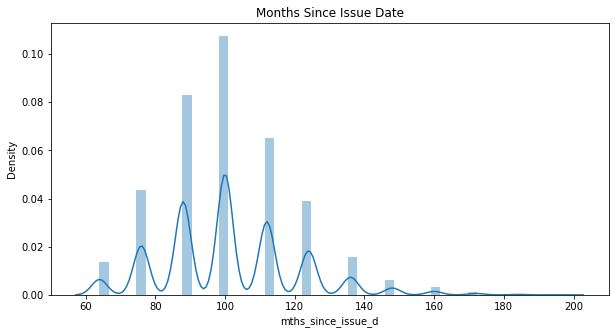

In [16]:
# Plot the distribution of the new column
plt.figure(figsize = (10, 5))
sns.distplot(X_train['mths_since_issue_d'])
plt.title('Months Since Issue Date')
plt.show()


In [17]:
# mort_acc column
X_train['mort_acc'].describe()

count    45450.000000
mean         1.683630
std          2.017776
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         24.000000
Name: mort_acc, dtype: float64

In [18]:
# mort_acc - fill in the missing values with 0
# It is better replace the empty values with 0 instead of the mean because the mean is 1.68.
def mort_acc_converter(df, column):
    df[column].fillna(value = 0, inplace = True)

mort_acc_converter(X_train, 'mort_acc')

In [19]:
# revol_util column - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
X_train['revol_util'].describe()

count    47057.000000
mean        52.001833
std         24.456244
min          0.000000
25%         33.700000
50%         52.500000
75%         70.800000
max        162.000000
Name: revol_util, dtype: float64

In [20]:
X_train['revol_util'].value_counts()

0.0      241
53.0     110
65.0     109
54.0     107
59.0     105
        ... 
162.0      1
102.2      1
106.1      1
123.9      1
109.5      1
Name: revol_util, Length: 1069, dtype: int64

In [21]:
# revol_util
# Fill in the missing values with the mean. Because the mean it is more representative than the median.
def revol_util_converter(df, column):
    df[column].fillna(value = df[column].mean(), inplace = True)

revol_util_converter(X_train, 'revol_util')

In [22]:
# pub_rec_bankruptcies
X_train['pub_rec_bankruptcies'].value_counts()

0.0    41200
1.0     5525
2.0      255
3.0       58
4.0       14
5.0        4
7.0        2
6.0        2
Name: pub_rec_bankruptcies, dtype: int64

In [23]:
# pub_rec_bankruptcies column: Number of public record bankruptcies
def pub_rec_bankruptcies_converter(df, column):
    df[column].fillna(value = 0, inplace = True)

pub_rec_bankruptcies_converter(X_train, 'pub_rec_bankruptcies')

## Feature Selection

In [24]:
# First divide training data into categorical and numerical subsets
X_train_num = X_train.select_dtypes(include = np.number).copy()
X_train_cat = X_train.select_dtypes(include = np.object).copy()

In [25]:
# initialize an empty dictionary to store the results of chi-square test
chi_sq_results = {}

# loop over all the categorical variables
for col in X_train_cat.columns:
    chi, pi, dof, expected = chi2_contingency(pd.crosstab(y_train, X_train_cat[col]))

    chi_sq_results.setdefault('Feature', []).append(col)
    chi_sq_results.setdefault('p-value', []).append(round(pi, 10))


# convert the dictionary to a dataframe
chi_sq_results = pd.DataFrame(chi_sq_results)

# sort the dataframe by p_value
chi_sq_results.sort_values(by = 'p-value', ascending = True, ignore_index=True, inplace = True)

chi_sq_results


,Feature,p-value
0,sub_grade,0.0
1,home_ownership,0.0
2,verification_status,0.0
3,purpose,0.0
4,addr_state,0.0


None of the categorical variable seem to have predictive power

## ANOVA F-Statistic for numerical variables

In [26]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47081 entries, 40113 to 54711
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             47081 non-null  int64  
 1   term                  47081 non-null  int64  
 2   int_rate              47081 non-null  float64
 3   installment           47081 non-null  float64
 4   emp_length            47081 non-null  float64
 5   annual_inc            47081 non-null  float64
 6   dti                   47081 non-null  float64
 7   fico_range_low        47081 non-null  int64  
 8   fico_range_high       47081 non-null  int64  
 9   open_acc              47081 non-null  int64  
 10  pub_rec               47081 non-null  int64  
 11  revol_bal             47081 non-null  int64  
 12  revol_util            47081 non-null  float64
 13  mort_acc              47081 non-null  float64
 14  pub_rec_bankruptcies  47081 non-null  float64
 15  age            

In [27]:
# Since f_class_if does not accept missing values, wee will do a avery crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)

# Calculate the F Statistic and corresponding p value
f_stat, p_value = f_classif(X_train_num, y_train)

# Create a dataframe to store the results
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': f_stat, 'p values': p_value.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,int_rate,3151.639885,0.000000e+00
1,age,1452.585787,0.000000e+00
2,term,1413.446461,0.000000e+00
3,fico_range_low,836.414496,0.000000e+00
4,fico_range_high,836.405040,0.000000e+00
5,pay_status,633.958937,0.000000e+00
6,dti,570.765914,0.000000e+00
7,mort_acc,200.495962,0.000000e+00
8,loan_amnt,196.117426,0.000000e+00
9,revol_util,179.722477,0.000000e+00


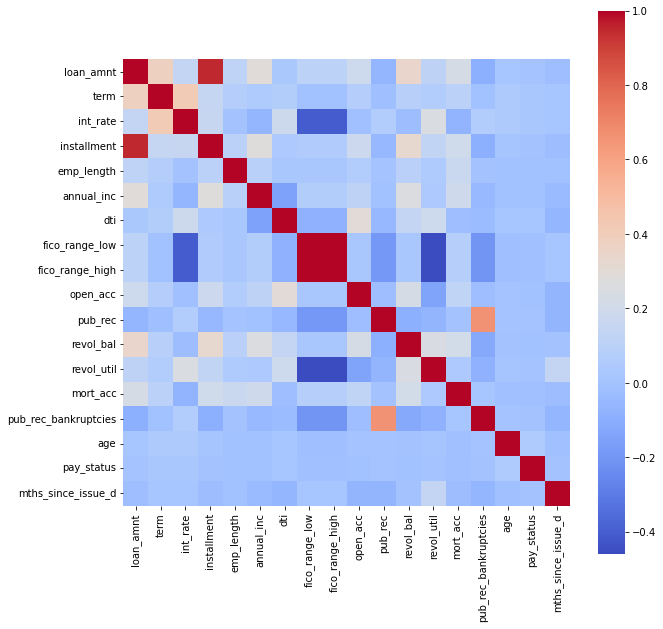

In [28]:
# Calculate the pair-wise correlations between the variables
corrmat = X_train_num.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corrmat, annot = False, square = True, cmap = 'coolwarm');


- The ANOVA F-Statistic is used to identify the numerical variables that are most predictive of the target variable.
- Those columns are: 'pub_rec', 'emp_length', 'pub_rec_bankruptcies', 'open_acc', 'revol_bal'

In [29]:
drop_columns_list = ['pub_rec', 'emp_length', 'pub_rec_bankruptcies', 'open_acc', 'revol_bal']

def col_to_drop(df, column_list):
    df.drop(columns = column_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)
col_to_drop(X, drop_columns_list)

## Creaty dummy variables for categorical variables

In [30]:
X_train_cat.columns

Index(['sub_grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state'],
      dtype='object')

In [31]:
def create_dummy(df, column_list):
    '''
    This function will create dummy variables for the categorical variables

    df: the dataframe
    column_list: list of categorical columns
    '''
    df_dummies = []
    for col in column_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to X_train
X_train = create_dummy(X_train, ['sub_grade', 'home_ownership', 'verification_status', 'purpose'])


In [32]:
X_train.sample(5)

,loan_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,fico_range_low,fico_range_high,revol_util,mort_acc,age,pay_status,mths_since_issue_d,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding
591,2000,36,13.11,67.50,B4,RENT,32000.0,Source Verified,credit_card,TX,10.91,700,704,39.0,0.0,52,0,124.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
28034,15000,36,12.59,502.46,C2,RENT,66000.0,Verified,debt_consolidation,NJ,6.40,700,704,0.0,0.0,28,0,100.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12720,4000,36,12.13,133.11,B5,RENT,55000.0,Not Verified,credit_card,NY,18.33,680,684,11.2,0.0,39,0,64.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
12751,5000,36,12.13,166.39,B5,RENT,37000.0,Source Verified,debt_consolidation,CA,22.92,695,699,10.0,0.0,22,0,64.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4155,25000,60,9.17,521.03,B2,MORTGAGE,102500.0,Source Verified,debt_consolidation,OH,21.99,705,709,45.3,4.0,25,-1,100.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Update the test set

In [33]:
# Apply the same transformations to the test set
emp_length_converter(X_test, 'emp_length')
date_converter(X_test, 'issue_d')
mort_acc_converter(X_test, 'mort_acc')
revol_util_converter(X_test, 'revol_util')
pub_rec_bankruptcies_converter(X_test, 'pub_rec_bankruptcies')
col_to_drop(X_test, drop_columns_list) # <<< I don't think this is necessary!

X_test = create_dummy(X_test, ['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state']) # <<< I don't think this is necessary!

# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

# Weight of Evidence (WoE) - Binning / Feature Engineering

- We will analyze both categorical and numerical features on their categorical/binned WoEs and IVs (Information Value) and then combine some of these binned categories together through a custom Python Class with fit_transform method.

In [34]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

## Analyze WoEs and IVs of discrete features

In [35]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df


sns.set()
# Function for plotting WoE across categoris that takes 2 arguments: a dataframe and a number
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = 'dotted', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)    


### 'sub_grade'

In [36]:
df = woe_discrete(X_train_prepr, 'sub_grade', y_train_prepr)
df

,sub_grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,A1,1604,0.034913,0.034069,56.0,1548.0,0.005947,0.041100,-1.933179,NaN,NaN,0.463088
1,A2,1254,0.053429,0.026635,67.0,1187.0,0.007115,0.031516,-1.488304,0.018516,0.444876,0.463088
2,A3,1338,0.053812,0.028419,72.0,1266.0,0.007646,0.033613,-1.480763,0.000383,0.007540,0.463088
3,A4,1889,0.076760,0.040122,145.0,1744.0,0.015398,0.046304,-1.101015,0.022949,0.379749,0.463088
4,A5,2340,0.084615,0.049702,198.0,2142.0,0.021026,0.056871,-0.995040,0.007855,0.105975,0.463088
5,B1,2514,0.103023,0.053397,259.0,2255.0,0.027503,0.059871,-0.777889,0.018408,0.217151,0.463088
6,B2,2566,0.121980,0.054502,313.0,2253.0,0.033238,0.059818,-0.587627,0.018957,0.190262,0.463088
7,B3,2944,0.138587,0.062531,408.0,2536.0,0.043326,0.067332,-0.440888,0.016607,0.146739,0.463088
8,B4,2846,0.162684,0.060449,463.0,2383.0,0.049166,0.063270,-0.252200,0.024098,0.188688,0.463088
9,B5,2910,0.171478,0.061808,499.0,2411.0,0.052989,0.064013,-0.189003,0.008793,0.063198,0.463088


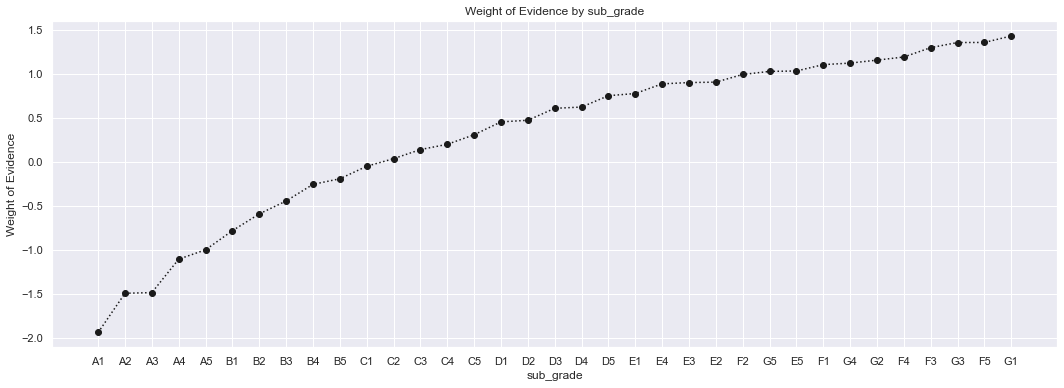

In [37]:
plot_by_woe(df)

In [38]:
# Combine sub_grades:
#  A1,A2,A3,A4,A5 as A
#  B1,B2,B3,B4,B5 as B etc
# Create a dictionary to map the sub_grades to the grades
sub_grade_dict = {'A1':'A', 'A2':'A', 'A3':'A', 'A4':'A', 'A5':'A',
                    'B1':'B', 'B2':'B', 'B3':'B', 'B4':'B', 'B5':'B',
                    'C1':'C', 'C2':'C', 'C3':'C', 'C4':'C', 'C5':'C',
                    'D1':'D', 'D2':'D', 'D3':'D', 'D4':'D', 'D5':'D',
                    'E1':'E', 'E2':'E', 'E3':'E', 'E4':'E', 'E5':'E',
                    'F1':'F', 'F2':'F', 'F3':'F', 'F4':'F', 'F5':'F',
                    'G1':'G', 'G2':'G', 'G3':'G', 'G4':'G', 'G5':'G'}


# Apply the dictionary to the sub_grade column
X_train_prepr['sub_grade'] = X_train_prepr['sub_grade'].map(sub_grade_dict)
X_test_prepr['sub_grade'] = X_test_prepr['sub_grade'].map(sub_grade_dict)

X['sub_grade'] = X['sub_grade'].map(sub_grade_dict)

In [39]:
X_train['sub_grade'] = X_train['sub_grade'].map(sub_grade_dict)
X_test['sub_grade'] = X_test['sub_grade'].map(sub_grade_dict)

In [40]:
# Plot the WoE for the new sub_grade column
df = woe_discrete(X_train_prepr, 'sub_grade', y_train_prepr)
df

,sub_grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,A,8425,0.063858,0.178947,538.0,7887.0,0.057131,0.209404,-1.298924,NaN,NaN,0.429227
1,B,13780,0.140929,0.292687,1942.0,11838.0,0.206223,0.314305,-0.421408,0.077071,0.877516,0.429227
2,C,13090,0.220779,0.278031,2890.0,10200.0,0.306892,0.270816,0.125057,0.079850,0.546465,0.429227
3,D,7111,0.306005,0.151038,2176.0,4935.0,0.231071,0.131027,0.567324,0.085226,0.442267,0.429227
4,E,3232,0.378094,0.068648,1222.0,2010.0,0.129765,0.053367,0.888542,0.072089,0.321218,0.429227
5,F,1127,0.444543,0.023937,501.0,626.0,0.053202,0.016621,1.163444,0.066449,0.274902,0.429227
6,G,316,0.468354,0.006712,148.0,168.0,0.015716,0.004460,1.259436,0.023811,0.095993,0.429227


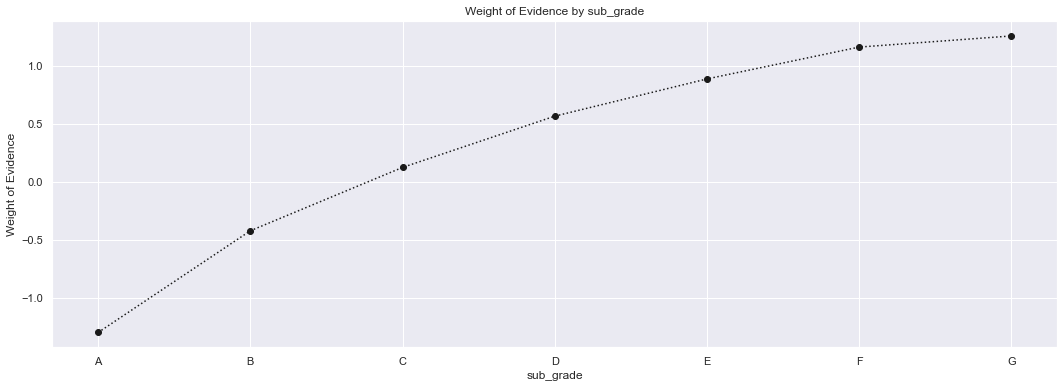

In [41]:
plot_by_woe(df)

We can see from the above graph that there is a continuous increase in WoE across the different grades. Therefore, we do not need to combine any features together and should leave all these 7 grades as they are

### home_ownership

In [42]:
df = woe_discrete(X_train_prepr, 'home_ownership', y_train_prepr)
df

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,ANY,8,0.125000,0.000170,1.0,7.0,0.000106,0.000186,-0.559722,NaN,NaN,0.030969
1,MORTGAGE,23216,0.173027,0.493108,4017.0,19199.0,0.426569,0.509744,-0.178135,0.048027,0.381587,0.030969
2,OWN,5098,0.203021,0.108281,1035.0,4063.0,0.109908,0.107875,0.018668,0.029994,0.196803,0.030969
3,RENT,18748,0.232505,0.398207,4359.0,14389.0,0.462886,0.382036,0.191967,0.029484,0.173299,0.030969
4,OTHER,8,0.375000,0.000170,3.0,5.0,0.000319,0.000133,0.875363,0.142495,0.683396,0.030969
5,NONE,3,0.666667,0.000064,2.0,1.0,0.000212,0.000027,2.079335,0.291667,1.203973,0.030969


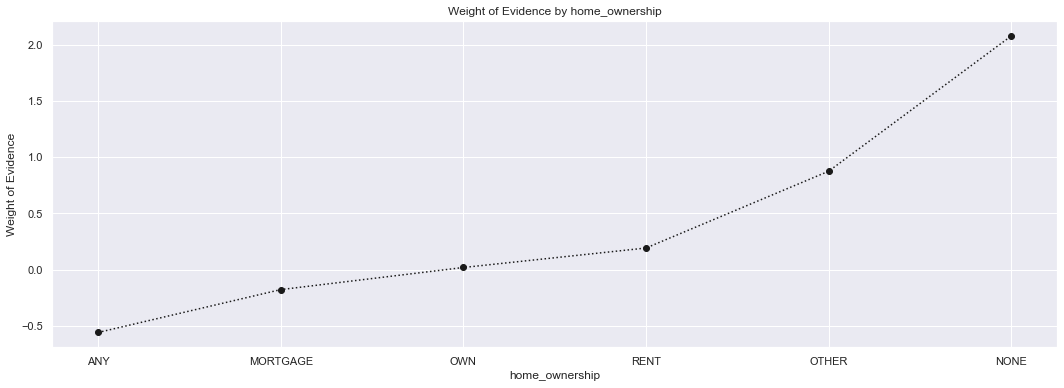

In [43]:
plot_by_woe(df)

### verification_status 

In [44]:
df = woe_discrete(X_train_prepr, 'verification_status', y_train_prepr)
df

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Not Verified,14247,0.147821,0.302606,2106.0,12141.0,0.223638,0.322350,-0.365610,NaN,NaN,0.053058
1,Source Verified,18428,0.211960,0.391411,3906.0,14522.0,0.414782,0.385567,0.073037,0.064139,0.438647,0.053058
2,Verified,14406,0.236360,0.305983,3405.0,11001.0,0.361580,0.292083,0.213447,0.024400,0.140410,0.053058


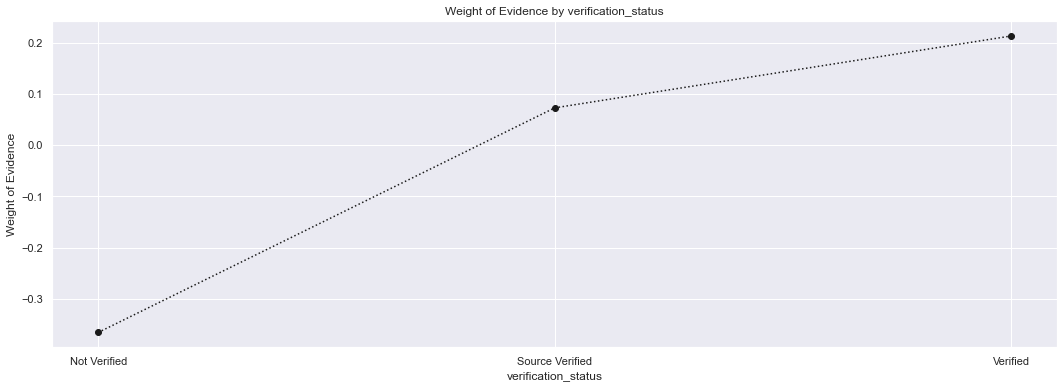

In [45]:
plot_by_woe(df)

### purpose

In [46]:
df = woe_discrete(X_train_prepr, 'purpose', y_train_prepr)
df

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,wedding,75,0.120000,0.001593,9.0,66.0,0.000956,0.001752,-0.606242,NaN,NaN,0.016402
1,car,496,0.163306,0.010535,81.0,415.0,0.008601,0.011018,-0.247641,0.043306,0.358601,0.016402
2,educational,12,0.166667,0.000255,2.0,10.0,0.000212,0.000266,-0.223250,0.003360,0.024391,0.016402
3,credit_card,10465,0.170760,0.222277,1787.0,8678.0,0.189763,0.230406,-0.194065,0.004093,0.029185,0.016402
4,vacation,339,0.174041,0.007200,59.0,280.0,0.006265,0.007434,-0.171064,0.003282,0.023001,0.016402
5,renewable_energy,34,0.176471,0.000722,6.0,28.0,0.000637,0.000743,-0.154257,0.002429,0.016807,0.016402
6,house,255,0.184314,0.005416,47.0,208.0,0.004991,0.005523,-0.101202,0.007843,0.053055,0.016402
7,major_purchase,1013,0.188549,0.021516,191.0,822.0,0.020282,0.021825,-0.073279,0.004235,0.027924,0.016402
8,home_improvement,2956,0.195196,0.062785,577.0,2379.0,0.061272,0.063164,-0.030405,0.006647,0.042874,0.016402
9,other,2745,0.199636,0.058304,548.0,2197.0,0.058193,0.058332,-0.002385,0.004439,0.028020,0.016402


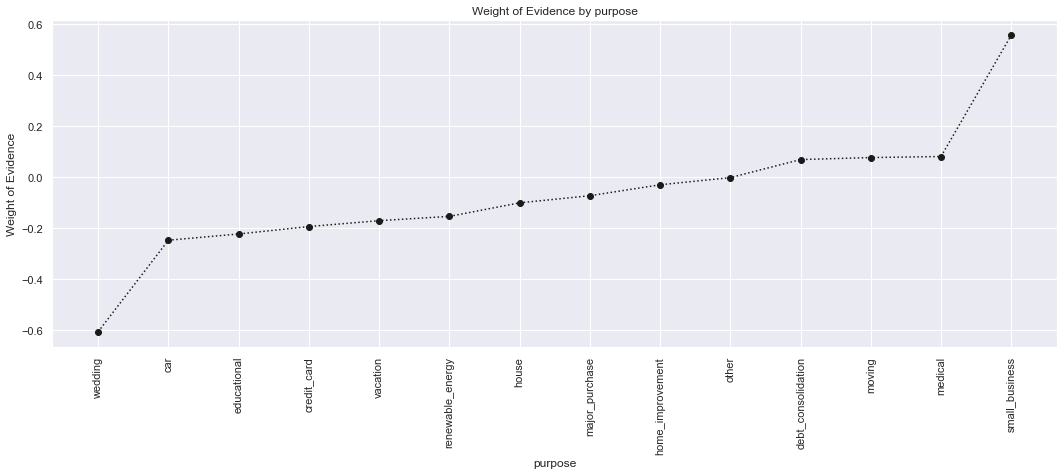

In [47]:
plot_by_woe(df, 90)

### addr_state

In [48]:
df = woe_discrete(X_train_prepr, 'addr_state', y_train_prepr)
df

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,IA,1,0.000000,0.000021,0.0,1.0,0.000000,0.000027,-inf,NaN,NaN,inf
1,VT,88,0.079545,0.001869,7.0,81.0,0.000743,0.002151,-1.062351,0.079545,inf,inf
2,OR,592,0.116554,0.012574,69.0,523.0,0.007327,0.013886,-0.639287,0.037009,0.423064,inf
3,DC,142,0.119718,0.003016,17.0,125.0,0.001805,0.003319,-0.608912,0.003164,0.030375,inf
4,ME,47,0.127660,0.000998,6.0,41.0,0.000637,0.001089,-0.535624,0.007941,0.073288,inf
5,RI,205,0.141463,0.004354,29.0,176.0,0.003080,0.004673,-0.417000,0.013804,0.118624,inf
6,SC,540,0.144444,0.011470,78.0,462.0,0.008283,0.012266,-0.392668,0.002981,0.024332,inf
7,WY,99,0.151515,0.002103,15.0,84.0,0.001593,0.002230,-0.336578,0.007071,0.056089,inf
8,NH,226,0.154867,0.004800,35.0,191.0,0.003717,0.005071,-0.310737,0.003352,0.025841,inf
9,ID,56,0.160714,0.001189,9.0,47.0,0.000956,0.001248,-0.266735,0.005847,0.044002,inf


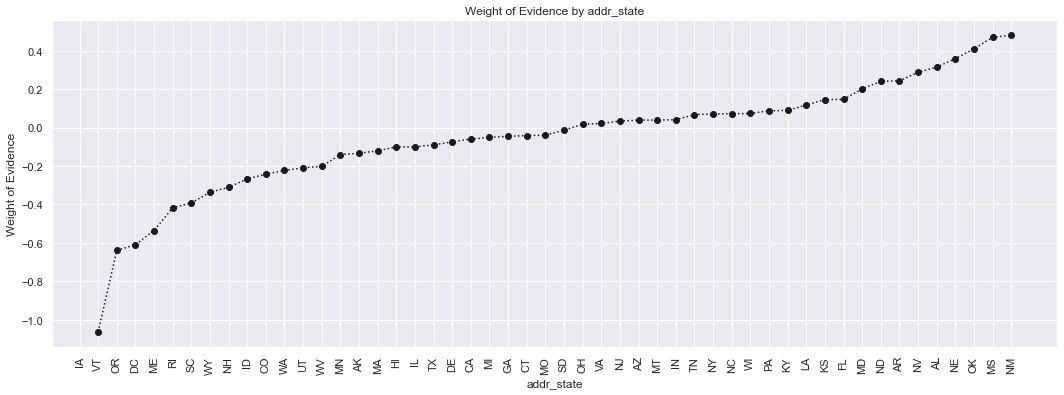

In [49]:
plot_by_woe(df, 90)

### Analyze WoEs and IVs of numeric features

In [50]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the 2 commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [51]:
X_train_prepr['loan_amnt_factor'] = pd.cut(X_train_prepr['loan_amnt'], 10)
df = woe_ordered_continuous(X_train_prepr, 'loan_amnt_factor', y_train_prepr)
df

,loan_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(961.0, 4900.0]",4652,0.158856,0.098808,739.0,3913.0,0.078475,0.103892,-0.280574,NaN,NaN,0.032332
1,"(4900.0, 8800.0]",9792,0.166565,0.207982,1631.0,8161.0,0.173197,0.216679,-0.223985,0.007708,0.056588,0.032332
2,"(8800.0, 12700.0]",10304,0.192352,0.218857,1982.0,8322.0,0.210470,0.220954,-0.048608,0.025788,0.175377,0.032332
3,"(12700.0, 16600.0]",6899,0.216698,0.146535,1495.0,5404.0,0.158755,0.143479,0.101175,0.024346,0.149783,0.032332
4,"(16600.0, 20500.0]",5657,0.223086,0.120155,1262.0,4395.0,0.134013,0.116690,0.138418,0.006388,0.037243,0.032332
5,"(20500.0, 24400.0]",3106,0.241790,0.065971,751.0,2355.0,0.079749,0.062527,0.243298,0.018704,0.104879,0.032332
6,"(24400.0, 28300.0]",2735,0.227788,0.058091,623.0,2112.0,0.066157,0.056075,0.165344,0.014002,0.077954,0.032332
7,"(28300.0, 32200.0]",1621,0.246761,0.034430,400.0,1221.0,0.042476,0.032418,0.270227,0.018973,0.104883,0.032332
8,"(32200.0, 36100.0]",2096,0.237118,0.044519,497.0,1599.0,0.052777,0.042454,0.217644,0.009643,0.052583,0.032332
9,"(36100.0, 40000.0]",219,0.168950,0.004652,37.0,182.0,0.003929,0.004832,-0.206901,0.068169,0.424545,0.032332


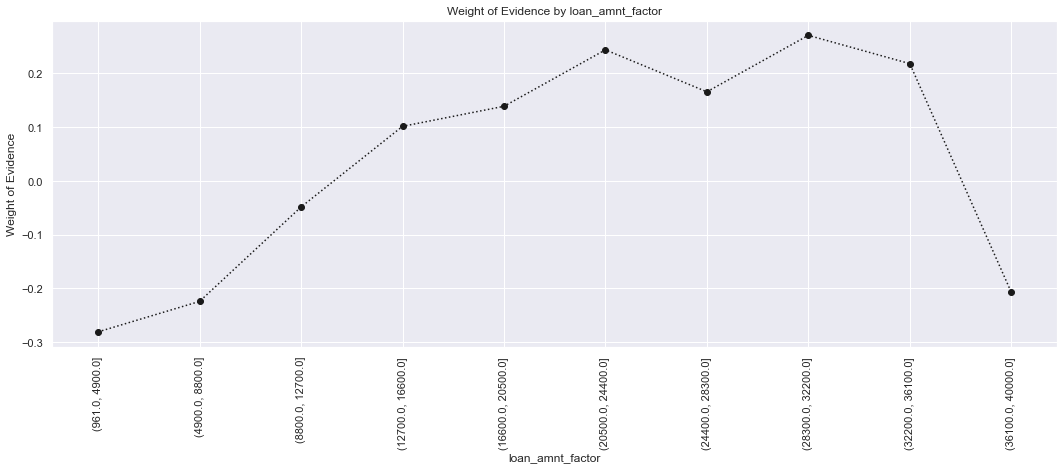

In [52]:
plot_by_woe(df, 90)

In [53]:
df = woe_ordered_continuous(X_train_prepr, 'term', y_train_prepr)
df

,term,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,36014,0.162159,0.764937,5840.0,30174.0,0.620155,0.801136,-0.256062,NaN,NaN,0.163463
1,60,11067,0.323213,0.235063,3577.0,7490.0,0.379845,0.198864,0.647144,0.161054,0.903205,0.163463


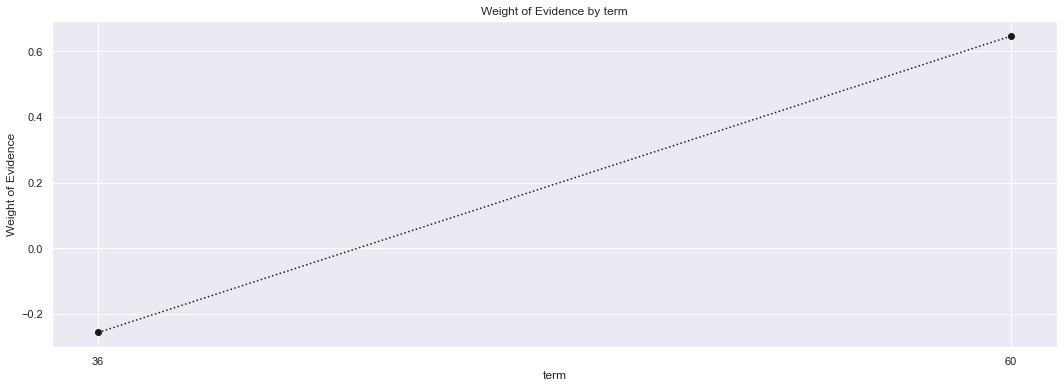

In [54]:
plot_by_woe(df)

In [55]:
X_train_prepr['int_rate_factor'] = pd.cut(X_train_prepr['int_rate'], 10)

df = woe_ordered_continuous(X_train_prepr, 'int_rate_factor', y_train_prepr)
df

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.284, 7.878]",5627,0.054558,0.119517,307.0,5320.0,0.032601,0.141249,-1.466193,NaN,NaN,0.416978
1,"(7.878, 10.446]",8459,0.110533,0.179669,935.0,7524.0,0.099289,0.199766,-0.699118,0.055975,0.767074,0.416978
2,"(10.446, 13.014]",10952,0.171110,0.232620,1874.0,9078.0,0.199002,0.241026,-0.191591,0.060577,0.507528,0.416978
3,"(13.014, 15.582]",8592,0.218575,0.182494,1878.0,6714.0,0.199427,0.178260,0.112201,0.047465,0.303791,0.416978
4,"(15.582, 18.15]",6447,0.282147,0.136934,1819.0,4628.0,0.193161,0.122876,0.452350,0.063571,0.340150,0.416978
5,"(18.15, 20.718]",3682,0.336230,0.078206,1238.0,2444.0,0.131464,0.064890,0.706049,0.054084,0.253699,0.416978
6,"(20.718, 23.286]",1628,0.389435,0.034579,634.0,994.0,0.067325,0.026391,0.936500,0.053205,0.230451,0.416978
7,"(23.286, 25.854]",1083,0.399815,0.023003,433.0,650.0,0.045981,0.017258,0.979954,0.010380,0.043454,0.416978
8,"(25.854, 28.422]",328,0.466463,0.006967,153.0,175.0,0.016247,0.004646,1.251840,0.066648,0.271887,0.416978
9,"(28.422, 30.99]",283,0.515901,0.006011,146.0,137.0,0.015504,0.003637,1.449814,0.049438,0.197974,0.416978


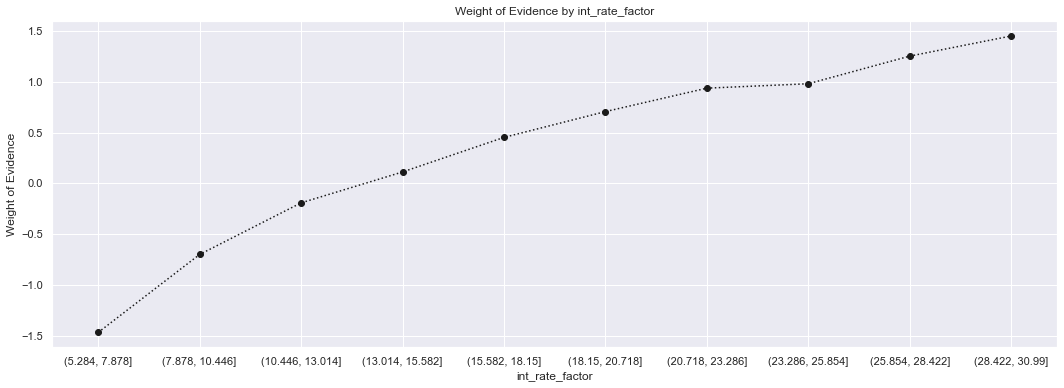

In [56]:
plot_by_woe(df)

In [57]:
X_train_prepr['installment_factor'] = pd.cut(X_train_prepr['installment'], 10)

df = woe_ordered_continuous(X_train_prepr, 'installment_factor', y_train_prepr)
df


,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(29.224, 179.348]",6636,0.154008,0.140949,1022.0,5614.0,0.108527,0.149055,-0.317314,NaN,NaN,0.031519
1,"(179.348, 327.986]",12768,0.178102,0.271192,2274.0,10494.0,0.241478,0.278621,-0.143075,0.024093,0.174239,0.031519
2,"(327.986, 476.624]",10703,0.221994,0.227332,2376.0,8327.0,0.252310,0.221086,0.132103,0.043892,0.275178,0.031519
3,"(476.624, 625.262]",7167,0.222827,0.152227,1597.0,5570.0,0.169587,0.147887,0.136920,0.000833,0.004817,0.031519
4,"(625.262, 773.9]",4445,0.213723,0.094412,950.0,3495.0,0.100881,0.092794,0.083561,0.009104,0.053358,0.031519
5,"(773.9, 922.538]",2659,0.222640,0.056477,592.0,2067.0,0.062865,0.054880,0.135841,0.008917,0.052280,0.031519
6,"(922.538, 1071.176]",1235,0.242105,0.026231,299.0,936.0,0.031751,0.024851,0.245016,0.019465,0.109175,0.031519
7,"(1071.176, 1219.814]",1021,0.182174,0.021686,186.0,835.0,0.019752,0.022170,-0.115497,0.059931,0.360513,0.031519
8,"(1219.814, 1368.452]",419,0.255370,0.008900,107.0,312.0,0.011362,0.008284,0.316014,0.073196,0.431511,0.031519
9,"(1368.452, 1517.09]",28,0.500000,0.000595,14.0,14.0,0.001487,0.000372,1.386188,0.244630,1.070174,0.031519


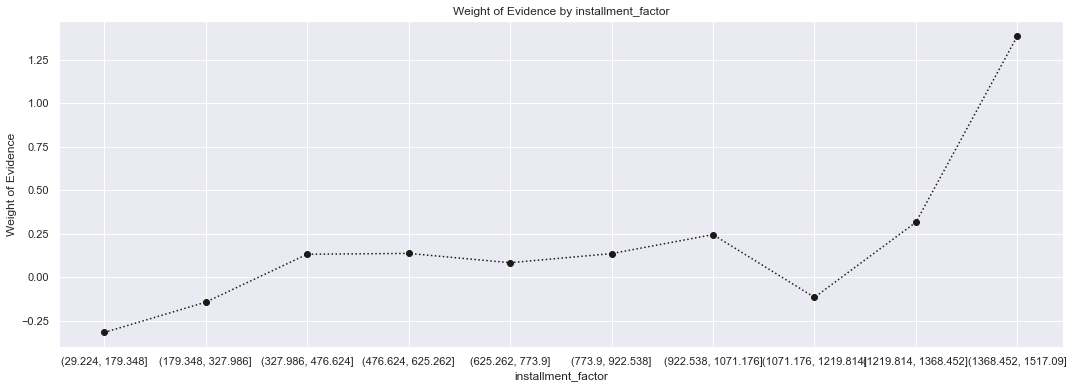

In [58]:
plot_by_woe(df)

In [59]:
X_train_prepr['annual_inc_factor'] = pd.cut(X_train_prepr['annual_inc'], 20)
# 
df = woe_ordered_continuous(X_train_prepr, 'annual_inc_factor', y_train_prepr)
df

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-297.026, 356296.3]",46910,0.200320,0.996368,9397.0,37513.0,0.997876,0.995991,0.001891,NaN,NaN,inf
1,"(356296.3, 705897.6]",140,0.121429,0.002974,17.0,123.0,0.001805,0.003266,-0.592783,0.078891,0.594674,inf
2,"(705897.6, 1055498.9]",22,0.090909,0.000467,2.0,20.0,0.000212,0.000531,-0.916397,0.030519,0.323614,inf
3,"(1055498.9, 1405100.2]",1,0.000000,0.000021,0.0,1.0,0.000000,0.000027,-inf,0.090909,inf,inf
4,"(1405100.2, 1754701.5]",2,0.000000,0.000042,0.0,2.0,0.000000,0.000053,-inf,0.000000,NaN,inf
5,"(1754701.5, 2104302.8]",1,0.000000,0.000021,0.0,1.0,0.000000,0.000027,-inf,0.000000,NaN,inf
6,"(2104302.8, 2453904.1]",1,0.000000,0.000021,0.0,1.0,0.000000,0.000027,-inf,0.000000,NaN,inf
7,"(2453904.1, 2803505.4]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(2803505.4, 3153106.7]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(3153106.7, 3502708.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


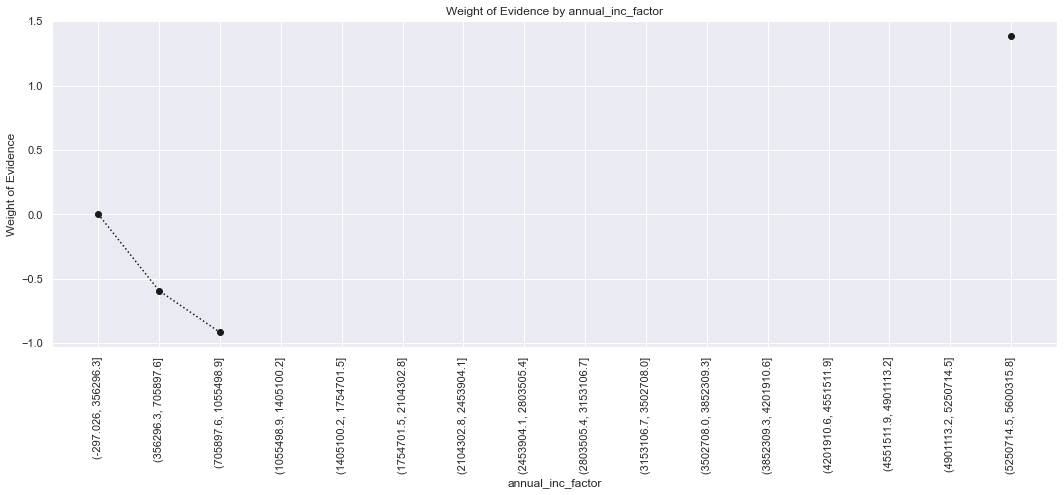

In [60]:
plot_by_woe(df, 90)

In [61]:
# Most of them are < 350.000
X_train_prepr_temp = X_train_prepr[X_train_prepr['annual_inc'] <= 350000].copy()

X_train_prepr_temp['annual_inc_factor'] = pd.cut(X_train_prepr_temp['annual_inc'], 20)
# 
df = woe_ordered_continuous(X_train_prepr_temp, 'annual_inc_factor', y_train_prepr[X_train_prepr_temp.index])
df


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(6351.695, 23860.25]",1101,0.246140,0.023471,271.0,830.0,0.028839,0.022127,0.264937,NaN,NaN,0.036372
1,"(23860.25, 41025.5]",7624,0.238720,0.162531,1820.0,5804.0,0.193679,0.154728,0.224533,0.007420,0.040404,0.036372
2,"(41025.5, 58190.75]",10541,0.216393,0.224716,2281.0,8260.0,0.242737,0.220202,0.097433,0.022327,0.127100,0.036372
3,"(58190.75, 75356.0]",10197,0.205060,0.217383,2091.0,8106.0,0.222518,0.216097,0.029282,0.011333,0.068151,0.036372
4,"(75356.0, 92521.25]",6260,0.185463,0.133453,1161.0,5099.0,0.123550,0.135933,-0.095519,0.019597,0.124801,0.036372
5,"(92521.25, 109686.5]",3924,0.163354,0.083653,641.0,3283.0,0.068213,0.087521,-0.249240,0.022110,0.153721,0.036372
6,"(109686.5, 126851.75]",2835,0.164374,0.060437,466.0,2369.0,0.049590,0.063155,-0.241794,0.001020,0.007446,0.036372
7,"(126851.75, 144017.0]",1460,0.147945,0.031125,216.0,1244.0,0.022986,0.033164,-0.366565,0.016429,0.124771,0.036372
8,"(144017.0, 161182.25]",1134,0.137566,0.024175,156.0,978.0,0.016601,0.026072,-0.451410,0.010379,0.084845,0.036372
9,"(161182.25, 178347.5]",441,0.174603,0.009401,77.0,364.0,0.008194,0.009704,-0.169105,0.037037,0.282305,0.036372


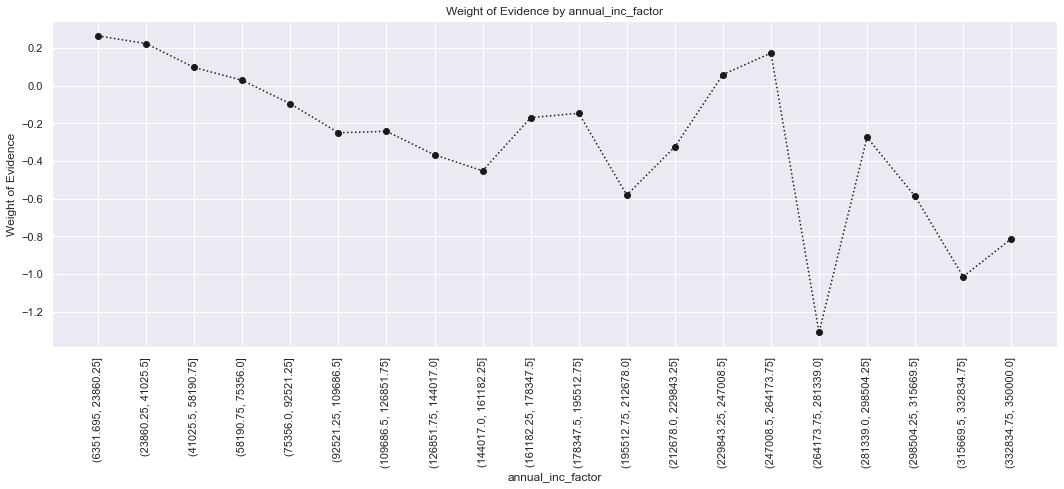

In [62]:
plot_by_woe(df, 90)

In [63]:
# dti
X_train_prepr['dti_factor'] = pd.cut(X_train_prepr['dti'], 20)
df = woe_ordered_continuous(X_train_prepr, 'dti_factor', y_train_prepr)
df

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.0499, 2.497]",720,0.165278,0.015293,119.0,601.0,0.012637,0.015957,-0.233283,NaN,NaN,0.076923
1,"(2.497, 4.994]",1588,0.142947,0.033729,227.0,1361.0,0.024105,0.036135,-0.404837,0.022331,0.171554,0.076923
2,"(4.994, 7.491]",2649,0.147225,0.056265,390.0,2259.0,0.041414,0.059978,-0.370343,0.004278,0.034494,0.076923
3,"(7.491, 9.988]",3669,0.151267,0.077930,555.0,3114.0,0.058936,0.082678,-0.338507,0.004042,0.031836,0.076923
4,"(9.988, 12.485]",4537,0.165748,0.096366,752.0,3785.0,0.079856,0.100494,-0.229877,0.014481,0.108630,0.076923
5,"(12.485, 14.982]",5231,0.168610,0.111106,882.0,4349.0,0.093660,0.115468,-0.209321,0.002862,0.020556,0.076923
6,"(14.982, 17.479]",5094,0.176482,0.108197,899.0,4195.0,0.095466,0.111380,-0.154177,0.007872,0.055144,0.076923
7,"(17.479, 19.976]",5131,0.196063,0.108982,1006.0,4125.0,0.106828,0.109521,-0.024896,0.019581,0.129282,0.076923
8,"(19.976, 22.473]",4525,0.219890,0.096111,995.0,3530.0,0.105660,0.093723,0.119878,0.023826,0.144774,0.076923
9,"(22.473, 24.97]",3824,0.226464,0.081222,866.0,2958.0,0.091961,0.078537,0.157804,0.006575,0.037927,0.076923


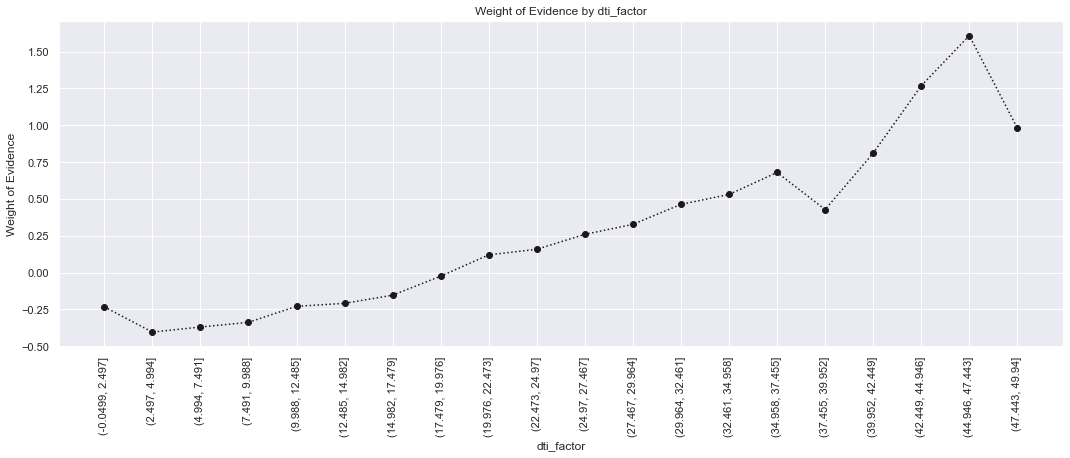

In [64]:
plot_by_woe(df, 90)

In [65]:
# fico_range_low and fico_range_high
X_train_prepr['fico_range_low_factor'] = pd.cut(X_train_prepr['fico_range_low'], 20)
df = woe_ordered_continuous(X_train_prepr, 'fico_range_low_factor', y_train_prepr)
df

,fico_range_low_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(659.815, 669.25]",8355,0.263315,0.177460,2200.0,6155.0,0.233620,0.163419,0.357381,NaN,NaN,0.131576
1,"(669.25, 678.5]",7819,0.240952,0.166075,1884.0,5935.0,0.200064,0.157578,0.238718,0.022364,0.118662,0.131576
2,"(678.5, 687.75]",6806,0.231120,0.144559,1573.0,5233.0,0.167038,0.138939,0.184188,0.009832,0.054530,0.131576
3,"(687.75, 697.0]",5898,0.197185,0.125273,1163.0,4735.0,0.123500,0.125717,-0.017791,0.033934,0.201979,0.131576
4,"(697.0, 706.25]",4803,0.177181,0.102016,851.0,3952.0,0.090368,0.104928,-0.149377,0.020005,0.131586,0.131576
5,"(706.25, 715.5]",3744,0.158654,0.079523,594.0,3150.0,0.063077,0.083634,-0.282090,0.018527,0.132713,0.131576
6,"(715.5, 724.75]",1537,0.148992,0.032646,229.0,1308.0,0.024318,0.034728,-0.356344,0.009662,0.074254,0.131576
7,"(724.75, 734.0]",2313,0.142240,0.049128,329.0,1984.0,0.034937,0.052676,-0.410624,0.006752,0.054280,0.131576
8,"(734.0, 743.25]",1584,0.132576,0.033644,210.0,1374.0,0.022300,0.036480,-0.492186,0.009664,0.081561,0.131576
9,"(743.25, 752.5]",1171,0.117848,0.024872,138.0,1033.0,0.014654,0.027427,-0.626781,0.014728,0.134595,0.131576


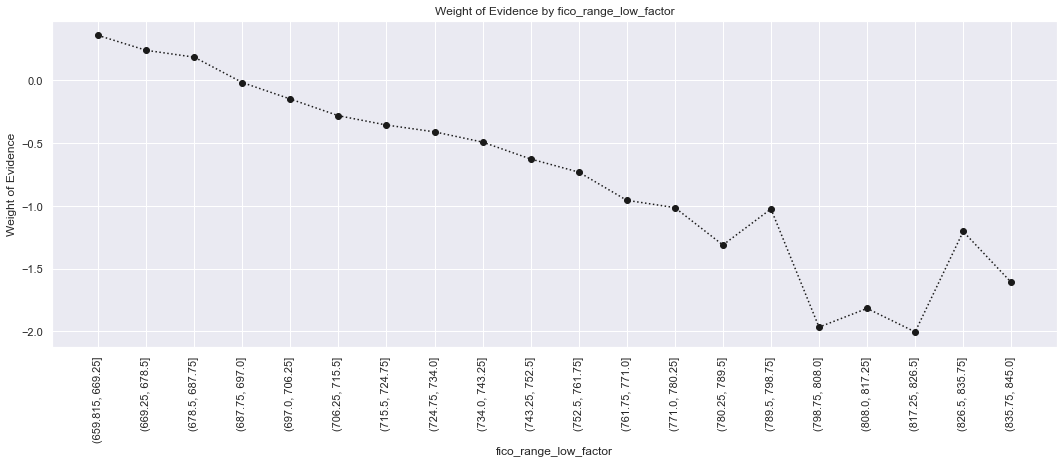

In [66]:
plot_by_woe(df, 90)

In [67]:
# fico_range_low and fico_range_high
X_train_prepr['fico_range_high_factor'] = pd.cut(X_train_prepr['fico_range_high'], 20)
df = woe_ordered_continuous(X_train_prepr, 'fico_range_high_factor', y_train_prepr)
df

,fico_range_high_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(663.814, 673.3]",8355,0.263315,0.177460,2200.0,6155.0,0.233620,0.163419,0.357381,NaN,NaN,0.131919
1,"(673.3, 682.6]",7819,0.240952,0.166075,1884.0,5935.0,0.200064,0.157578,0.238718,0.022364,0.118662,0.131919
2,"(682.6, 691.9]",6806,0.231120,0.144559,1573.0,5233.0,0.167038,0.138939,0.184188,0.009832,0.054530,0.131919
3,"(691.9, 701.2]",5898,0.197185,0.125273,1163.0,4735.0,0.123500,0.125717,-0.017791,0.033934,0.201979,0.131919
4,"(701.2, 710.5]",4803,0.177181,0.102016,851.0,3952.0,0.090368,0.104928,-0.149377,0.020005,0.131586,0.131919
5,"(710.5, 719.8]",3744,0.158654,0.079523,594.0,3150.0,0.063077,0.083634,-0.282090,0.018527,0.132713,0.131919
6,"(719.8, 729.1]",2790,0.150179,0.059260,419.0,2371.0,0.044494,0.062951,-0.347008,0.008475,0.064918,0.131919
7,"(729.1, 738.4]",1060,0.131132,0.022514,139.0,921.0,0.014761,0.024453,-0.504798,0.019047,0.157790,0.131919
8,"(738.4, 747.7]",1584,0.132576,0.033644,210.0,1374.0,0.022300,0.036480,-0.492186,0.001444,0.012612,0.131919
9,"(747.7, 757.0]",1171,0.117848,0.024872,138.0,1033.0,0.014654,0.027427,-0.626781,0.014728,0.134595,0.131919


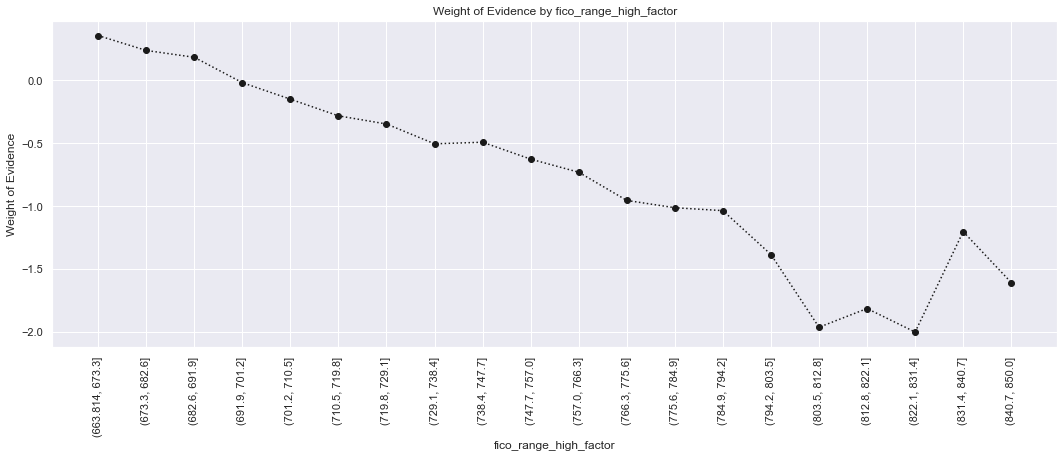

In [68]:
plot_by_woe(df, 90)

In [69]:
X_train_prepr['mort_acc_factor'] = pd.cut(X_train_prepr['mort_acc'], 10)
df = woe_ordered_continuous(X_train_prepr, 'mort_acc_factor', y_train_prepr)
df


,mort_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.024, 2.4]",34450,0.213759,0.731718,7364.0,27086.0,0.781990,0.719148,0.083774,NaN,NaN,inf
1,"(2.4, 4.8]",8154,0.168261,0.173191,1372.0,6782.0,0.145694,0.180066,-0.211814,0.045498,0.295589,inf
2,"(4.8, 7.2]",3805,0.153482,0.080818,584.0,3221.0,0.062016,0.085519,-0.321358,0.014779,0.109544,inf
3,"(7.2, 9.6]",486,0.144033,0.010323,70.0,416.0,0.007433,0.011045,-0.396002,0.009449,0.074644,inf
4,"(9.6, 12.0]",149,0.161074,0.003165,24.0,125.0,0.002549,0.003319,-0.264072,0.017041,0.131930,inf
5,"(12.0, 14.4]",21,0.095238,0.000446,2.0,19.0,0.000212,0.000504,-0.865104,0.065836,0.601032,inf
6,"(14.4, 16.8]",7,0.142857,0.000149,1.0,6.0,0.000106,0.000159,-0.405571,0.047619,0.459532,inf
7,"(16.8, 19.2]",5,0.000000,0.000106,0.0,5.0,0.000000,0.000133,-inf,0.142857,inf,inf
8,"(19.2, 21.6]",1,0.000000,0.000021,0.0,1.0,0.000000,0.000027,-inf,0.000000,NaN,inf
9,"(21.6, 24.0]",3,0.000000,0.000064,0.0,3.0,0.000000,0.000080,-inf,0.000000,NaN,inf


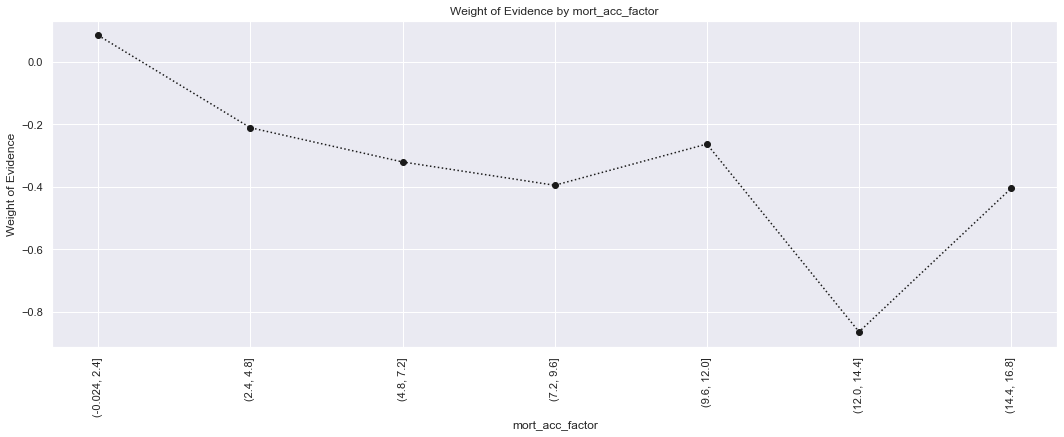

In [70]:
plot_by_woe(df, 90)

In [71]:
# X_train_prepr['age'].describe()

In [72]:
X_train_prepr['age_factor'] = pd.cut(X_train_prepr['age'], 4)
df = woe_ordered_continuous(X_train_prepr, 'age_factor', y_train_prepr)
df

,age_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(19.942, 34.5]",25007,0.153397,0.531148,3836.0,21171.0,0.407348,0.562102,-0.322014,NaN,NaN,0.107126
1,"(34.5, 49.0]",17977,0.240474,0.381831,4323.0,13654.0,0.459063,0.362521,0.236105,0.087077,0.558119,0.107126
2,"(49.0, 63.5]",3877,0.301522,0.082347,1169.0,2708.0,0.124137,0.071899,0.546126,0.061048,0.310021,0.107126
3,"(63.5, 78.0]",220,0.404545,0.004673,89.0,131.0,0.009451,0.003478,0.999627,0.103024,0.453501,0.107126


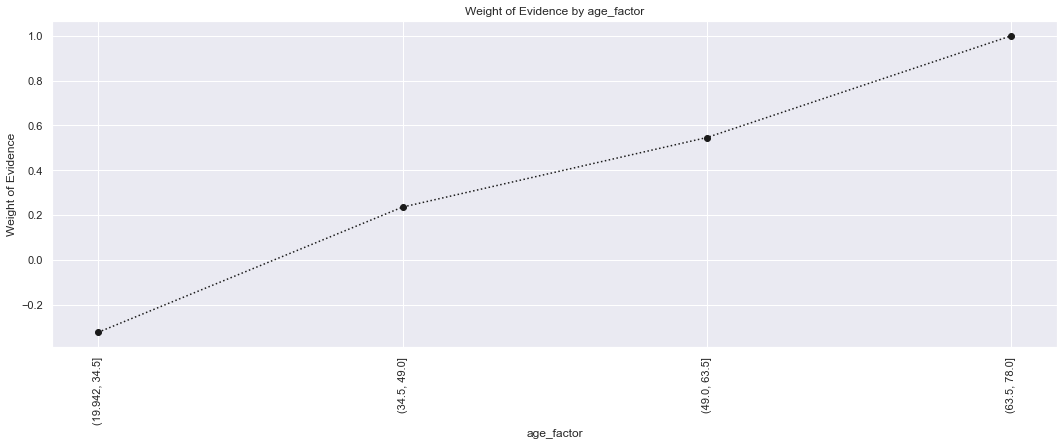

In [73]:
plot_by_woe(df, 90)

In [74]:
X_train_prepr['pay_status_factor'] = pd.cut(X_train_prepr['pay_status'], 10)
df = woe_ordered_continuous(X_train_prepr, 'pay_status_factor', y_train_prepr)
df

,pay_status_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-2.011, -0.9]",12433,0.152417,0.264077,1895.0,10538.0,0.201232,0.279790,-0.329581,NaN,NaN,0.141658
1,"(-0.9, 0.2]",22532,0.177303,0.478579,3995.0,18537.0,0.424233,0.492168,-0.148537,0.024886,0.181044,0.141658
2,"(0.2, 1.3]",6954,0.329451,0.147703,2291.0,4663.0,0.243283,0.123805,0.675518,0.152147,0.824055,0.141658
3,"(1.3, 2.4]",4212,0.205840,0.089463,867.0,3345.0,0.092068,0.088812,0.036005,0.123610,0.639512,0.141658
4,"(2.4, 3.5]",702,0.428775,0.014910,301.0,401.0,0.031963,0.010647,1.099337,0.222934,1.063332,0.141658
5,"(3.5, 4.6]",144,0.305556,0.003059,44.0,100.0,0.004672,0.002655,0.565208,0.123219,0.534129,0.141658
6,"(4.6, 5.7]",43,0.186047,0.000913,8.0,35.0,0.000850,0.000929,-0.089718,0.119509,0.654926,0.141658
7,"(5.7, 6.8]",16,0.312500,0.000340,5.0,11.0,0.000531,0.000292,0.597731,0.126453,0.687449,0.141658
8,"(6.8, 7.9]",16,0.187500,0.000340,3.0,13.0,0.000319,0.000345,-0.080149,0.125000,0.677880,0.141658
9,"(7.9, 9.0]",29,0.275862,0.000616,8.0,21.0,0.000850,0.000558,0.421107,0.088362,0.501256,0.141658


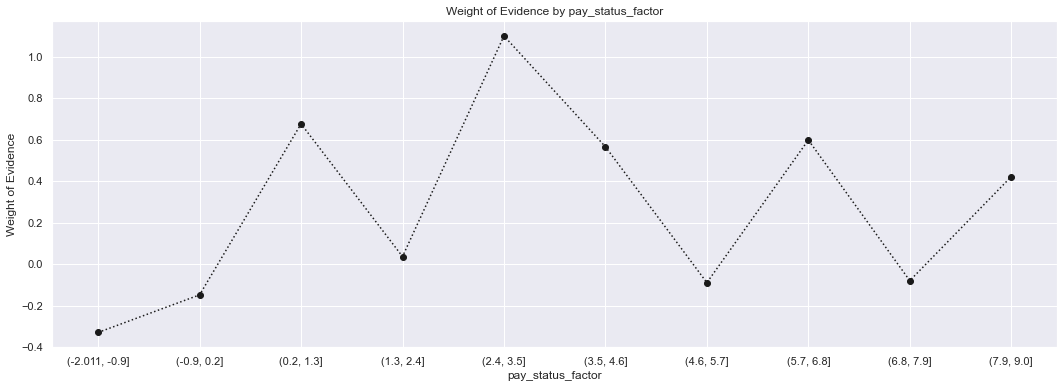

In [75]:
plot_by_woe(df)

# Define Custom Class from WoE Binning and Feature Engineering

In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58852 entries, 0 to 58851
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loan_amnt            58852 non-null  int64         
 1   term                 58852 non-null  int64         
 2   int_rate             58852 non-null  float64       
 3   installment          58852 non-null  float64       
 4   sub_grade            58852 non-null  object        
 5   home_ownership       58852 non-null  object        
 6   annual_inc           58852 non-null  float64       
 7   verification_status  58852 non-null  object        
 8   issue_d              58852 non-null  datetime64[ns]
 9   purpose              58852 non-null  object        
 10  addr_state           58852 non-null  object        
 11  dti                  58852 non-null  float64       
 12  fico_range_low       58852 non-null  int64         
 13  fico_range_high      58852 non-

In [77]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58852 entries, 0 to 58851
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loan_amnt            58852 non-null  int64         
 1   term                 58852 non-null  int64         
 2   int_rate             58852 non-null  float64       
 3   installment          58852 non-null  float64       
 4   sub_grade            58852 non-null  object        
 5   home_ownership       58852 non-null  object        
 6   annual_inc           58852 non-null  float64       
 7   verification_status  58852 non-null  object        
 8   issue_d              58852 non-null  datetime64[ns]
 9   purpose              58852 non-null  object        
 10  addr_state           58852 non-null  object        
 11  dti                  58852 non-null  float64       
 12  fico_range_low       58852 non-null  int64         
 13  fico_range_high      58852 non-

In [78]:
# Create Dummy Variables in the original dataset
X = create_dummy(X, ['sub_grade', 'home_ownership', 'verification_status', 'purpose'])

In [79]:
X

,loan_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,fico_range_low,fico_range_high,revol_util,mort_acc,age,pay_status,sub_grade:A,sub_grade:B,sub_grade:C,sub_grade:D,sub_grade:E,sub_grade:F,sub_grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding
0,35000,60,17.86,886.11,D,MORTGAGE,80000.0,Verified,2015-01-02,debt_consolidation,GA,22.20,740,744,64.6,2.0,27,2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,25000,60,14.85,592.79,C,RENT,75000.0,Not Verified,2016-01-01,debt_consolidation,CT,31.42,705,709,75.6,0.0,29,-1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,5000,36,10.15,161.69,B,MORTGAGE,16344.0,Verified,2014-01-05,debt_consolidation,FL,24.89,660,664,51.1,3.0,33,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,22000,60,15.59,530.22,C,MORTGAGE,80000.0,Not Verified,2016-01-09,debt_consolidation,TX,15.80,675,679,52.0,2.0,36,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,25000,36,6.89,770.68,A,OWN,59000.0,Verified,2015-01-07,debt_consolidation,WI,16.01,735,739,37.9,2.0,56,-1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58847,15000,36,13.18,506.72,C,RENT,100000.0,Source Verified,2015-01-12,debt_consolidation,NY,6.07,660,664,66.5,1.0,38,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
58848,16100,36,16.02,566.19,C,MORTGAGE,40000.0,Verified,2017-01-05,debt_consolidation,NE,31.08,670,674,71.8,2.0,42,-1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
58849,25000,36,6.89,770.68,A,OWN,92000.0,Not Verified,2015-01-07,home_improvement,NJ,15.82,770,774,31.8,4.0,36,4,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
58850,12000,36,19.03,440.06,D,OWN,43000.0,Source Verified,2017-01-07,credit_card,AR,16.38,665,669,81.1,0.0,44,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['home_ownership:NONE', 'verification_status:Not Verified', 'purpose:small_business', 'loan_amnt:>32201', 'term:60', 'int_rate:>25.855', 'installment:>1071.177', 'annual_inc:>298505', 'dti:>39.9522', 'fico_range_low:>771.0', 'fico_range_high:>738.4', 'age:>60', 'pay_status:>0.2']

class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ref_categories = []
        self.X = X
    
    def fit(self, X, y=None):
        self.ref_categories = X.columns.tolist()
        return self
    
    def transform(self, X):
        X_new = X.copy()

        ############## Categorical Variables #################
        # sub_grad
        # X_new = X_new.loc[:, 'sub_grade:A': 'sub_grade:G']
        # X_new['sub_grade:A'] = np.where(X_new['sub_grade'] == 0, 0, 1)


        # home_ownership                
        X_new['home_ownership:OWN'] = np.where(X_new['home_ownership:OWN'] == 1, 1, 0)
        X_new['home_ownership:RENT'] = np.where(X_new['home_ownership:RENT'] == 1, 1, 0)
        X_new['home_ownership:OTHER'] = np.where(X_new['home_ownership:OTHER'] == 1, 1, 0)
        X_new['home_ownership:NONE'] = np.where(X_new['home_ownership:NONE'] == 1, 1, 0)
        X_new['home_ownership:ANY_MORTGAGE'] = np.where((X['home_ownership:ANY'] == 1) | (X['home_ownership:MORTGAGE'] == 1), 1, 0)

        # verification_status
        X_new = pd.concat([X, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis=1)

        ## purpose
        X_new['purpose:small_business'] = np.where(X_new['purpose:small_business'] == 1, 1, 0)
        X_new['purpose:home_other_debt_moving_medical'] = sum([X['purpose:home_improvement'], X['purpose:other'], X['purpose:debt_consolidation'], X['purpose:moving']])        


        ############## Continuous Variables #################
        ## loan_amnt
        X_new['loan_amnt:<12701'] = np.where((X_new['loan_amnt'] <= 12701), 1, 0)
        X_new['loan_amnt:12701-24401'] = np.where((X_new['loan_amnt'] > 12701) & (X_new['loan_amnt'] <= 24401), 1, 0)
        X_new['loan_amnt:24401-32201'] = np.where((X_new['loan_amnt'] > 24401) & (X_new['loan_amnt'] <= 32201), 1, 0)
        X_new['loan_amnt:>32201'] = np.where((X_new['loan_amnt'] > 32201), 1, 0)

        ## term
        X_new['term:36'] = np.where((X_new['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X_new['term'] == 60), 1, 0)

        ## int_rate
        X_new['int_rate:<13.015'] = np.where((X_new['int_rate'] <= 13.015), 1, 0)
        X_new['int_rate:13.015-20.719'] = np.where((X_new['int_rate'] > 13.015) & (X_new['int_rate'] <= 20.719), 1, 0)
        X_new['int_rate:20.719-25.855'] = np.where((X_new['int_rate'] > 20.719) & (X_new['int_rate'] <= 25.855), 1, 0)
        X_new['int_rate:>25.855'] = np.where((X_new['int_rate'] > 25.855), 1, 0)

        ## installment
        X_new['installment:<327.987'] = np.where((X_new['installment'] <= 327.987), 1, 0)
        X_new['installment:327.987-1071.177'] = np.where((X_new['installment'] > 327.987) & (X_new['installment'] <= 1071.177), 1, 0)
        X_new['installment:>1071.177'] = np.where((X_new['installment'] > 1071.177), 1, 0)

        # annual_inc
        X_new['annual_inc:missing'] = np.where(X_new['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<75357'] = np.where((X_new['annual_inc'] <= 75357), 1, 0)
        X_new['annual_inc:75357-161183'] = np.where((X_new['annual_inc'] > 75357) & (X_new['annual_inc'] <= 161183), 1, 0)
        X_new['annual_inc:161183-195513'] = np.where((X_new['annual_inc'] > 161183) & (X_new['annual_inc'] <= 195513), 1, 0)
        X_new['annual_inc:195513-247009]'] = np.where((X_new['annual_inc'] > 195513) & (X_new['annual_inc'] <= 247009), 1, 0)
        X_new['annual_inc:247009-264174]]'] = np.where((X_new['annual_inc'] > 247009) & (X_new['annual_inc'] <= 264174), 1, 0)
        X_new['annual_inc:264174-281339]]'] = np.where((X_new['annual_inc'] > 264174) & (X_new['annual_inc'] <= 281339), 1, 0)
        X_new['annual_inc:281339-298505]]'] = np.where((X_new['annual_inc'] > 281339) & (X_new['annual_inc'] <= 298505), 1, 0)
        X_new['annual_inc:>298505]]'] = np.where((X_new['annual_inc'] > 298505), 1, 0)

        # dti
        X_new['dti:<19.977'] = np.where((X_new['dti'] <= 19.977), 1, 0)
        X_new['dti:19.977-37.455'] = np.where((X_new['dti'] > 19.977) & (X_new['dti'] <= 37.455), 1, 0)
        X_new['dti:37.455-39.9522'] = np.where((X_new['dti'] > 37.455) & (X_new['dti'] <= 39.9522), 1, 0)
        X_new['dti:>39.9522'] = np.where((X_new['dti'] > 39.9522), 1, 0)

        # fico_range_low
        X_new['fico_range_low:<697.01'] = np.where((X_new['fico_range_low'] <= 697.01), 1, 0)
        X_new['fico_range_low:697.01-771.0'] = np.where((X_new['fico_range_low'] > 697.01) & (X_new['fico_range_low'] <= 771.0), 1, 0)
        X_new['fico_range_low:>771.0'] = np.where((X_new['fico_range_low'] > 771.0), 1, 0)

        # fico_range_high
        X_new['fico_range_high:<691.9'] = np.where((X_new['fico_range_high'] <= 691.9), 1, 0)
        X_new['fico_range_high:691.9-738.4'] = np.where((X_new['fico_range_high'] > 691.9) & (X_new['fico_range_high'] <= 738.4), 1, 0)
        X_new['fico_range_high:>738.4'] = np.where((X_new['fico_range_high'] > 738.4), 1, 0)

        # # mort_acc - do not consider it

        # age
        X_new['age:<30'] = np.where((X['age'] <= 30), 1, 0)
        X_new['age:30-60'] = np.where((X['age'] > 30) & (X['age'] <= 60), 1, 0)
        X_new['age:>60'] = np.where((X['age'] > 60) , 1, 0)
                
        # pay_status
        X_new['pay_status:<-0.9'] = np.where((X_new['pay_status'] <= -0.9), 1, 0)
        X_new['pay_status:-0.9-0.2'] = np.where((X_new['pay_status'] > -0.9) & (X_new['pay_status'] <= 0.2), 1, 0)
        X_new['pay_status:>0.2'] = np.where((X_new['pay_status'] > 0.2), 1, 0)


        X_new.drop(columns = self.ref_categories, inplace = True)
        return X_new


# PD Model Estimation

In [81]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(47081, 76)
(47081,)
(11771, 76)
(11771,)


In [88]:
# transformed_data.info()

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

woe_binning = WoE_Binning()

pipeline = Pipeline([
    ('woe_binning', WoE_Binning()),
    ('model', LogisticRegression(max_iter=1000, class_weight = 'balanced'))
])

# pipeline = Pipeline([
#     ('woe_binning', WoE_Binning()),
#     ('model', GradientBoostingClassifier(random_state = 42))
# ])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))



Mean AUROC: 0.7281
Gini: 0.4562


In [91]:
# pretty impressive scores for the first time, now let's fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe_binning', WoE_Binning()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [92]:
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_binning.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,0.103424
1,purpose:home_other_debt_moving_medical,0.064510
2,loan_amnt:<12701,-0.007257
3,loan_amnt:12701-24401,-0.003043
4,loan_amnt:24401-32201,0.099454
5,loan_amnt:>32201,-0.005895
6,term:36,-0.277794
7,term:60,0.361053
8,int_rate:<13.015,-0.621622
9,int_rate:13.015-20.719,-0.082752


# Predictions

In [93]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [94]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(11771, 2)

In [95]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
32430,1,0.760519
8467,0,0.546221
3380,0,0.629318
3077,0,0.091637
2864,0,0.171889


## Confusion Matrix and AUROC on Test Set

In [96]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.53750743, 0.2624246 ],
       [0.06329114, 0.13677682]])

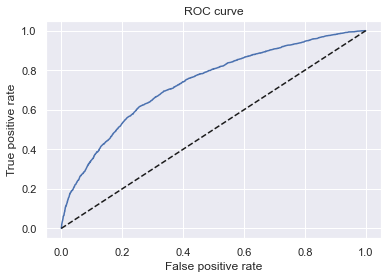

In [97]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [98]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.7340322836676786

In [99]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

0.4680645673353572

| Performance | Gini Coefficient |
| --- | --- |
| Adequate | >0.50 |
| Good | >0.60 |
| Excellent | >0.70 |

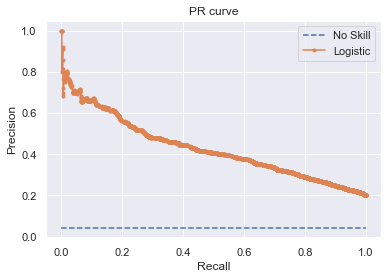

In [100]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [101]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.4303498787035766

# Applying the Model - Scorecard Creation

In [102]:
summary_table

,Feature name,Coefficients
0,Intercept,0.103424
1,purpose:home_other_debt_moving_medical,0.064510
2,loan_amnt:<12701,-0.007257
3,loan_amnt:12701-24401,-0.003043
4,loan_amnt:24401-32201,0.099454
5,loan_amnt:>32201,-0.005895
6,term:36,-0.277794
7,term:60,0.361053
8,int_rate:<13.015,-0.621622
9,int_rate:13.015-20.719,-0.082752


In [103]:
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list. We name it 'Feature name'.
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0
df_ref_categories

,Feature name,Coefficients
0,home_ownership:NONE,0
1,verification_status:Not Verified,0
2,purpose:small_business,0
3,loan_amnt:>32201,0
4,term:60,0
5,int_rate:>25.855,0
6,installment:>1071.177,0
7,annual_inc:>298505,0
8,dti:>39.9522,0
9,fico_range_low:>771.0,0


In [104]:
# Concatenates two dataframes.
df_scorecard = pd.concat([summary_table, df_ref_categories])
# We reset the index of a dataframe.
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature name,Coefficients
0,0,Intercept,0.103424
1,1,purpose:home_other_debt_moving_medical,0.064510
2,2,loan_amnt:<12701,-0.007257
3,3,loan_amnt:12701-24401,-0.003043
4,4,loan_amnt:24401-32201,0.099454
5,5,loan_amnt:>32201,-0.005895
6,6,term:36,-0.277794
7,7,term:60,0.361053
8,8,int_rate:<13.015,-0.621622
9,9,int_rate:13.015-20.719,-0.082752


In [105]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,Original feature name
0,0,Intercept,0.103424,Intercept
1,1,purpose:home_other_debt_moving_medical,0.064510,purpose
2,2,loan_amnt:<12701,-0.007257,loan_amnt
3,3,loan_amnt:12701-24401,-0.003043,loan_amnt
4,4,loan_amnt:24401-32201,0.099454,loan_amnt
5,5,loan_amnt:>32201,-0.005895,loan_amnt
6,6,term:36,-0.277794,term
7,7,term:60,0.361053,term
8,8,int_rate:<13.015,-0.621622,int_rate
9,9,int_rate:13.015-20.719,-0.082752,int_rate


In [106]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [107]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,0.103424,Intercept,569.322326,569.0
1,1,purpose:home_other_debt_moving_medical,0.064510,purpose,4.420340,4.0
2,2,loan_amnt:<12701,-0.007257,loan_amnt,-0.497249,-0.0
3,3,loan_amnt:12701-24401,-0.003043,loan_amnt,-0.208543,-0.0
4,4,loan_amnt:24401-32201,0.099454,loan_amnt,6.814754,7.0
5,5,loan_amnt:>32201,-0.005895,loan_amnt,-0.403917,-0.0
6,6,term:36,-0.277794,term,-19.034817,-19.0
7,7,term:60,0.361053,term,24.739863,25.0
8,8,int_rate:<13.015,-0.621622,int_rate,-42.594403,-43.0
9,9,int_rate:13.015-20.719,-0.082752,int_rate,-5.670253,-6.0


In [108]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

299.0
849.0


In [109]:
# so both our min and max scores are out by +1. we need to manually adjust this
# Which one? We'll evaluate based on the rounding differences of the minimum category within each Original Feature Name.
pd.options.display.max_rows = 51
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,0.103424,Intercept,569.322326,569.0,-0.322326
1,1,purpose:home_other_debt_moving_medical,0.064510,purpose,4.420340,4.0,-0.420340
2,2,loan_amnt:<12701,-0.007257,loan_amnt,-0.497249,-0.0,0.497249
3,3,loan_amnt:12701-24401,-0.003043,loan_amnt,-0.208543,-0.0,0.208543
4,4,loan_amnt:24401-32201,0.099454,loan_amnt,6.814754,7.0,0.185246
...,...,...,...,...,...,...,...
48,8,dti:>39.9522,0.000000,dti,0.000000,0.0,0.000000
49,9,fico_range_low:>771.0,0.000000,fico_range_low,0.000000,0.0,0.000000
50,10,fico_range_high:>738.4,0.000000,fico_range_high,0.000000,0.0,0.000000
51,11,age:>60,0.000000,age,0.000000,0.0,0.000000


In [110]:
# look like we can get by deducting 1 from the Intercept
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 598
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,0.103424,Intercept,569.322326,569.0,-0.322326,598.0
1,1,purpose:home_other_debt_moving_medical,0.064510,purpose,4.420340,4.0,-0.420340,4.0
2,2,loan_amnt:<12701,-0.007257,loan_amnt,-0.497249,-0.0,0.497249,-0.0
3,3,loan_amnt:12701-24401,-0.003043,loan_amnt,-0.208543,-0.0,0.208543,-0.0
4,4,loan_amnt:24401-32201,0.099454,loan_amnt,6.814754,7.0,0.185246,7.0
...,...,...,...,...,...,...,...,...
48,8,dti:>39.9522,0.000000,dti,0.000000,0.0,0.000000,0.0
49,9,fico_range_low:>771.0,0.000000,fico_range_low,0.000000,0.0,0.000000,0.0
50,10,fico_range_high:>738.4,0.000000,fico_range_high,0.000000,0.0,0.000000,0.0
51,11,age:>60,0.000000,age,0.000000,0.0,0.000000,0.0


In [111]:
# Recheck min and max possible scores
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

328.0
878.0


In [112]:
## Calculating credit scores for all observations in the test data set

In [124]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_binning.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,purpose:home_other_debt_moving_medical,loan_amnt:<12701,loan_amnt:12701-24401,loan_amnt:24401-32201,loan_amnt:>32201,term:36,term:60,int_rate:<13.015,int_rate:13.015-20.719,int_rate:20.719-25.855,int_rate:>25.855,installment:<327.987,installment:327.987-1071.177,installment:>1071.177,annual_inc:missing,annual_inc:<75357,annual_inc:75357-161183,annual_inc:161183-195513,annual_inc:195513-247009],annual_inc:247009-264174]],annual_inc:264174-281339]],annual_inc:281339-298505]],annual_inc:>298505]],dti:<19.977,dti:19.977-37.455,dti:37.455-39.9522,dti:>39.9522,fico_range_low:<697.01,fico_range_low:697.01-771.0,fico_range_low:>771.0,fico_range_high:<691.9,fico_range_high:691.9-738.4,fico_range_high:>738.4,age:<30,age:30-60,age:>60,pay_status:<-0.9,pay_status:-0.9-0.2,pay_status:>0.2
32430,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1
8467,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0
3380,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0
3077,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0
2864,1,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0


In [125]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(11771, 40)
(53,)


In [126]:
# we can see that the test set has 17 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard, it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is same shape to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(53, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(11771, 53)
(53, 1)


In [127]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

,0
32430,670.0
8467,602.0
3380,628.0
3077,433.0
2864,483.0


## Setting loan approval  cut-offfs

In [128]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.333017


In [129]:
# update the threshold value
tr = best_thresh
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.27992524, 0.5200068 ],
       [0.02268286, 0.1773851 ]])

In [130]:
# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs.head()

,thresholds,Score
0,0.089610,403.0
1,0.090073,404.0
2,0.090833,404.0
3,0.091287,405.0
4,0.091637,405.0


In [131]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [132]:
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs.head()

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,0.089610,403.0,11720,51,0.995667,0.004333
1,0.090073,404.0,11715,56,0.995243,0.004757
2,0.090833,404.0,11714,57,0.995158,0.004842
3,0.091287,405.0,11712,59,0.994988,0.005012
4,0.091637,405.0,11711,60,0.994903,0.005097


In [135]:
# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.3330, 0.3340)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
950,0.333017,515.0,8210,3561,0.697477,0.302523
951,0.333331,515.0,8209,3562,0.697392,0.302608
952,0.333390,515.0,8208,3563,0.697307,0.302693
953,0.333671,515.0,8206,3565,0.697137,0.302863
954,0.333892,515.0,8205,3566,0.697052,0.302948


In [134]:
# compare the above rates with the case of the default 0.5 threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.5, 0.5001)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
1836,0.500062,562.0,4699,7072,0.399201,0.600799
